# 快速傅里叶变换

## 频率域的信息

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy

plt.style.use(['ggplot','../../presentation.mplstyle'])

构造带有两个频率的信号

In [2]:
# Number of samplepoints
N = 600
# sample spacing
T = 1.0 / 800.0
x = np.linspace(0.0, N*T, N)
y = np.sin(50.0 * 2.0*np.pi*x) + 0.5*np.sin(80.0 * 2.0*np.pi*x)

傅里叶变换

In [3]:
yf = np.fft.fft(y)
xf = np.linspace(0.0, 1.0/(2.0*T), N//2)

展示频率域信息，可以清楚地看到两个频率信息。

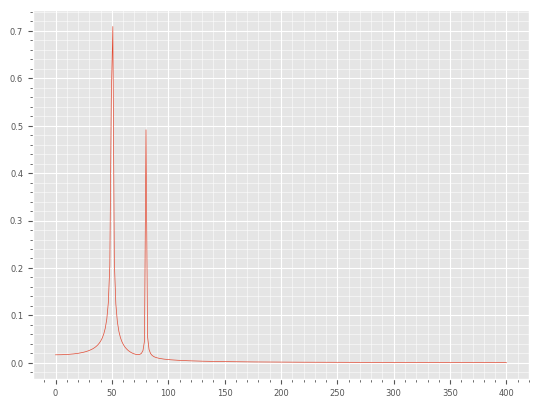

In [4]:
fig, ax = plt.subplots()
ax.plot(xf, 2.0/N * np.abs(yf[:N//2]))
ax.grid(zorder=0)
ax.grid(which='major', color='white', linestyle='-',alpha=1)
ax.grid(which='minor', color='white', linestyle='-',alpha=0.5)
plt.minorticks_on()
plt.show()

## 低通滤波器
[The Discrete Algebra
of the Fourier Transform](https://mathematical-tours.github.io/daft-sources/DAFT-EN.pdf), chapter 4, exercise 41:
1. Builds a vector $f$, of size $N$, such that the filter $\Phi^f$ keeps the low
frequencies $N/2$, and removes the $N/2$ high frequencies.
2. Represent with great precision the continuous Fourier transform of the impulse response $f$ (in other
words the frequency response of the filter). What do we see?
3. Considering a less brutal cut in the conserved / rejected frequencies, go back to the previous questions and comment on the results. In particular, imagine a family of filters $f_\epsilon$, $\epsilon\in[0,1]$, with a sharp cutoff for $\epsilon=0$ and soft for $\epsilon=1$.

### 低通滤波器设计之一：频率域简单的截断函数
函数`filter_pass_bas(N)`: $N$为信号的长度，在频率域上定义以下的截断函数$H(v)$，

$$
H(v)=\left\{
\begin{array}{cc}
1,& |v|\leq\frac{\pi}{2}\\
0,& |v|>\frac{\pi}{2}
\end{array}
\right.
$$
如果是用数组的指针，上述$|v|\leq\pi/2$相对应于$v\leq N/4$和$v\geq 3N/4$。

**注意**，在程序中，高频部分是在序列的中间，两头是低频部分。我们在数组的两头取$1$, 中间取$0$。用python中的list comprehansion实现。然后用傅里叶逆变换获取时间域上的滤波函数。

### 低通滤波器设计之二：截断函数的磨光


In [5]:
import math

def filter_pass_bas(N):
    v=[1 if (v<=N/4)|(v>=3*N/4) else 0 for v in range(0,N)]
    return np.real(np.fft.ifft(v))

def filter_parameterable(N,eps):
    #P1=math.floor(eps*N/4)
    P1=int((eps*N)//4)
    P=2*P1+1
    trans=[1]
    if P!=1:
        #ramp=np.arange(0,P)
        #trans=list(map(lambda x: (math.cos(math.pi*x/(P-1))+1)/2,ramp))
        trans=[(math.cos(math.pi*x/(P-1))+1)/2 for x in range(0,P)]
    ones = list(np.repeat(1,N/4-P1))
    x = ones+trans+list(np.repeat(0,N/2-P))
    trans.reverse()
    x = x+trans+ones[:-1]
    return np.real(np.fft.ifft(x))

def plot_function(ax,t,y,title='',color='#666666'):
    ax.minorticks_on()
    ax.plot(t,y,'--o',markevery=markers_on,linewidth=.5,markersize=2,color=color)
    ax.grid(zorder=0)
    ax.grid(which='major', color='white', linestyle='-',alpha=.5)
    ax.grid(which='minor', color='white', linestyle='-',alpha=0.25)
    ax.tick_params(axis='both', which='major', labelsize=6)
    ax.set_title(title,size=8,color='#888888')

In [6]:
leps=[0,.3,.7]
N=32
P=1024

In [7]:
c=list(range(int(N/2),N))+list(range(0,int(N/2)))
cc=list(range(P>>1,P))+list(range(0,P>>1))
t=list(np.arange(-N/2,N/2))
tt=[x*math.pi/(P-1) for x in np.arange(-P/2,P/2)]

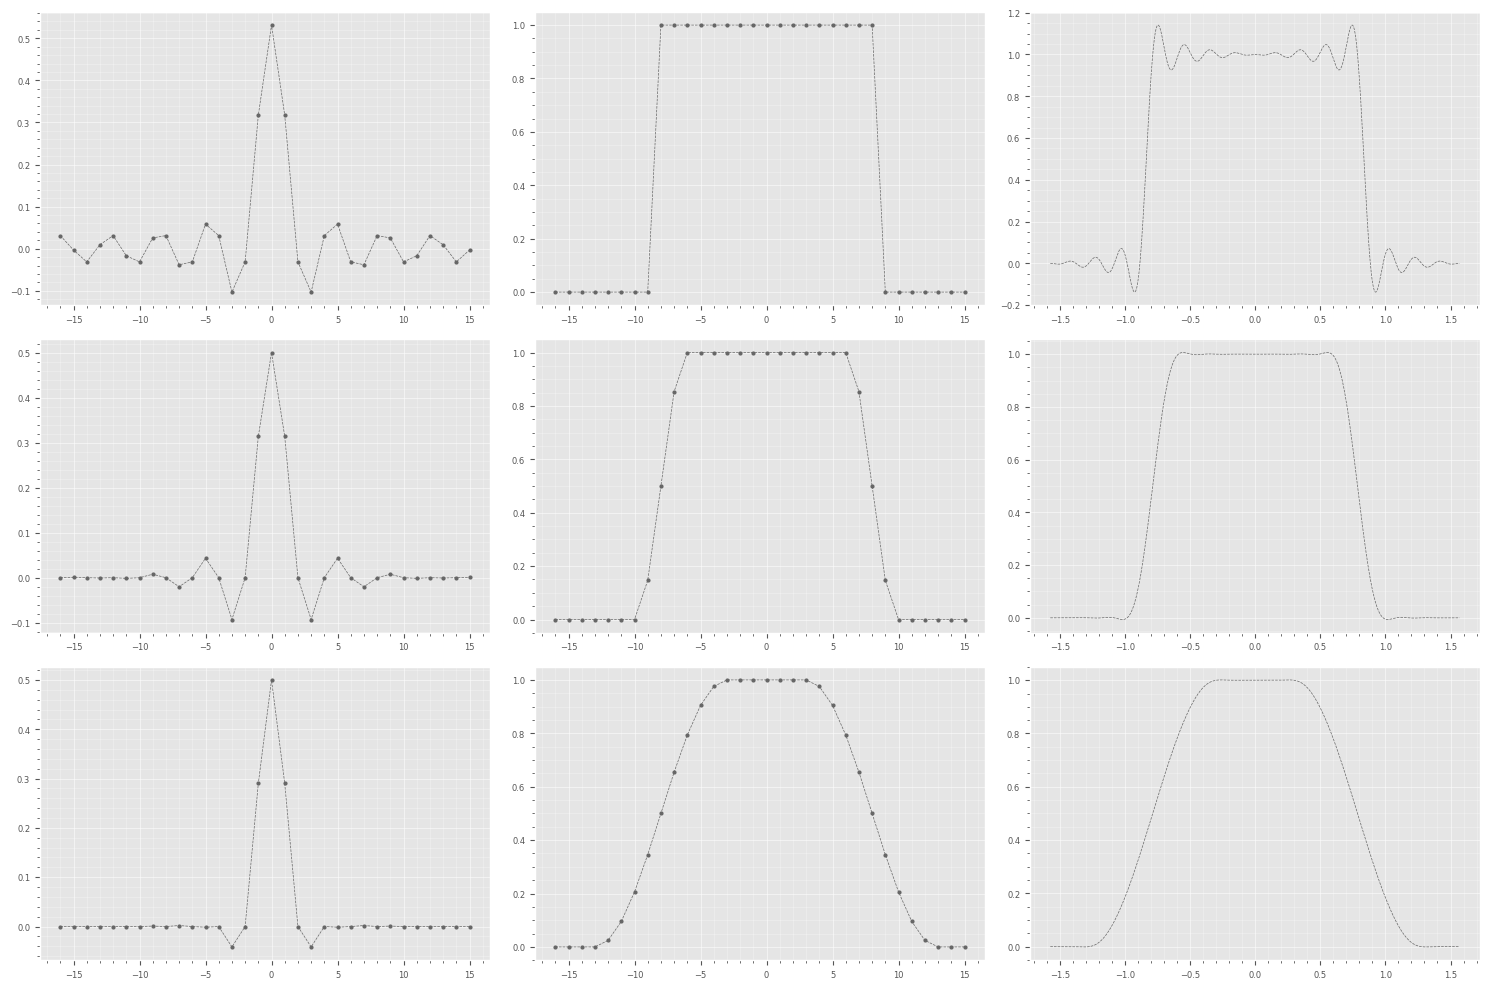

In [8]:
fig,axs = plt.subplots(len(leps),3,figsize=(15,10))
for i in range(len(leps)):
    markers_on = c
    y=filter_parameterable(N,leps[i])
    plot_function(axs[i,0],t,y[c])
    f=list(y)
    y=np.real(np.fft.fft(y))
    plot_function(axs[i,1],t,y[c])
    yy=f[0:int(N/2)]+list(np.repeat(0,P-N))+f[int(N/2):N]
    yy=np.real(np.fft.fft(yy))
    markers_on = []
    plot_function(axs[i,2],tt,yy[cc])
plt.tight_layout()

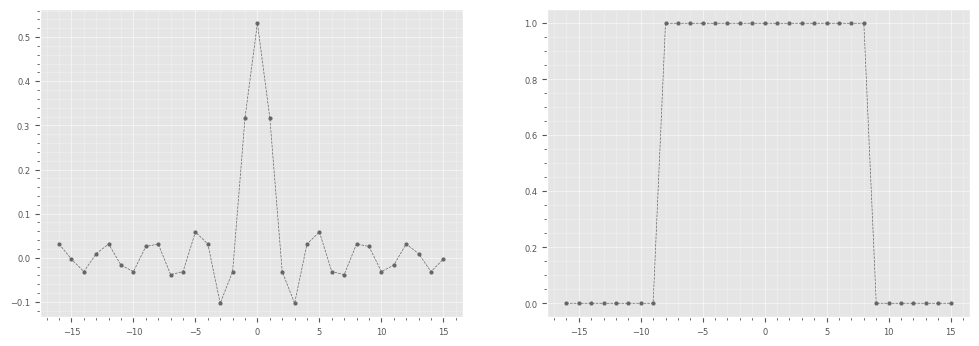

In [9]:
fig,ax=plt.subplots(1,2,figsize=(12,4))
markers_on = c
y=filter_pass_bas(N)
plot_function(ax[0],t,y[c])
yy=np.append(y[0:int(N/2)],list(np.repeat(0,P-N)))
yy=np.append(yy,y[int(N/2):N])
y=np.real(np.fft.fft(y))
plot_function(ax[1],t,y[c])

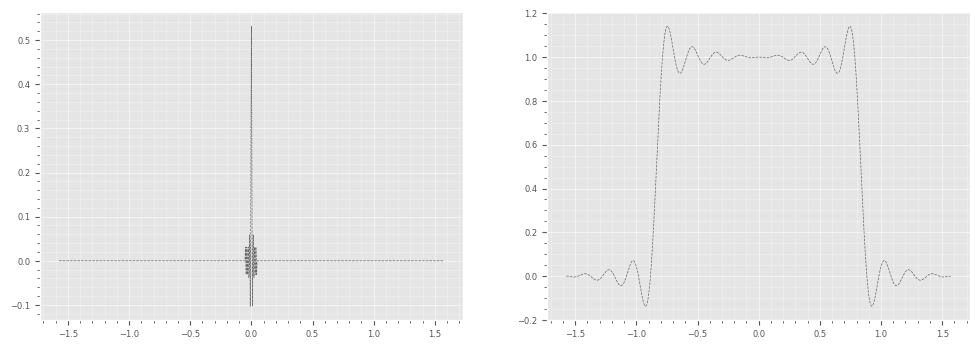

In [10]:
fig,ax=plt.subplots(1,2,figsize=(12,4))
yyf=np.real(np.fft.fft(yy))
markers_on=[]
plot_function(ax[0],tt,yy[cc])
plot_function(ax[1],tt,yyf[cc])

In [11]:
y=filter_parameterable(N,leps[2])

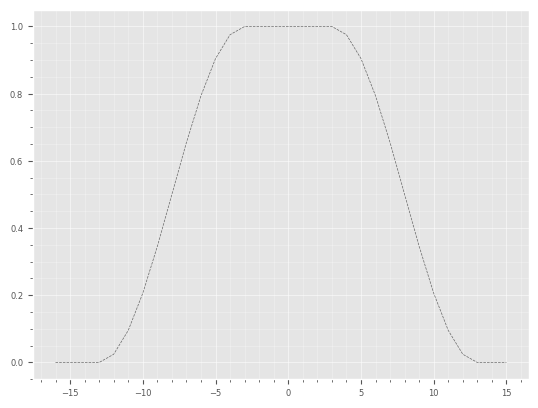

In [12]:
fig,ax=plt.subplots()
#plot_function(ax,t,y[c])
yf=np.real(np.fft.fft(y))
plot_function(ax,t,yf[c])

# 截断函数的磨光技术

上面用到的磨光技术值得重视，这是短期傅里叶变换（STFT）的关键技术之一。这里的材料主要参考{cite}`Wickerhauser:1994`第4章。

## 单边磨光

### 算法一：迭代正弦函数

In [13]:
def rcfis(t,N=1):
    if t>-1.0:
        if t<1.0:
            for i in range(0,N):
                t = np.sin(0.5*np.pi*t)
            t = np.sin(0.25*np.pi*(1.0+t))
        else:
            t = 1.0
    else:
        t = 0.0
    return t

In [14]:
N=4
t=np.linspace(-1.25,1.25,64)

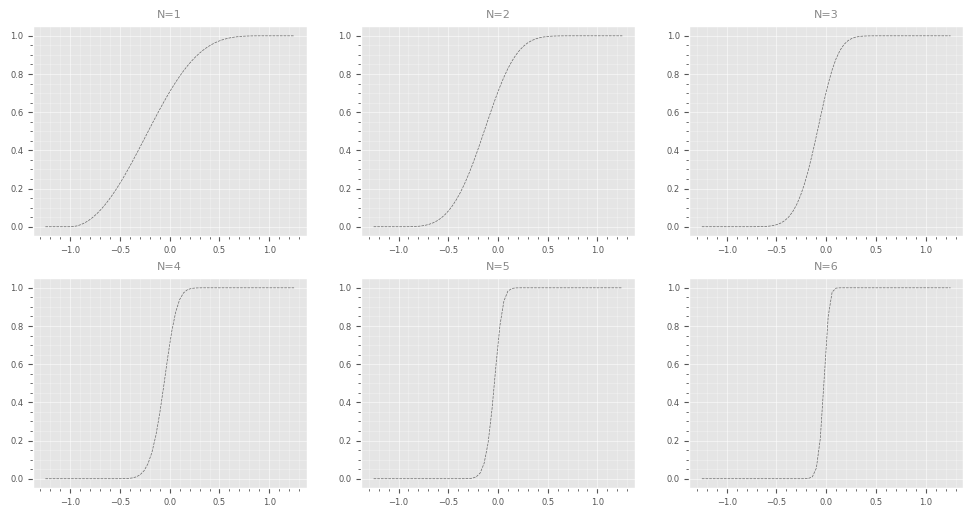

In [15]:
ns = [1,2,3,4,5,6]
m=3
fig,axs=plt.subplots(math.ceil(len(ns)/m),m,figsize=(12,6))
for i in range(len(ns)):
    x=[rcfis(v,ns[i]) for v in t]
    plot_function(axs[math.ceil((i+1)/m)-1,i%m],t,x,title='N='+str(ns[i]))

### 验证恒等式
rising cutoff函数$r(t)$的要求是

$$
|r(t)|^2+|r(-t)|^2=1,\quad\forall t\in\R
$$


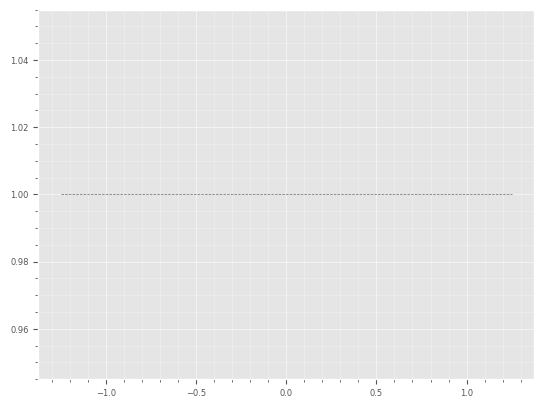

In [16]:
def rsum(t,N=-1):
    r1=rcfis(t,N)
    r2=rcfis(-t,N)
    return r1*r1+r2*r2
N=1
x=[rsum(v,N) for v in t]
fig,ax=plt.subplots()
plot_function(ax,t,x)

## 折叠算子
折叠算子（folding operator）$U$的定义：

$$
U(r)f(t)=
\left\{
\begin{array}{cc}
r(t)f(t)+r(-t)f(-t),&t>0\\
\bar{r}(-t)f(t)-\bar{r}(t)f(-t),&t<0
\end{array}
\right.
$$

逆折叠算子（unfolding operator）$U^*$:
$$
U^*(r)f(t)=
\left\{
\begin{array}{cc}
\bar{r}(t)f(t)-r(-t)f(-t),&t>0\\
r(-t)f(t)+\bar{r}(t)f(-t),&t<0
\end{array}
\right.
$$

我们可以看到，当$t\geq 1$或者$t\leq -1$时，$U(r)f(t)=f(t)$和$U^*(r)f(t)=f(t)$。而且，$U(r)U^*(r)f(t)=U^*(r)U(r)f(t)=(|r(t)|^2+|r(-t)|^2)f(t)=f(t),\quad\forall t\neq0$。

这个算子对给定的函数$f(t)$，其作用区间为$(-1,1)$。为了实现能够对任意区间进行作用，我们引入一下两个算子；
1. 平移（translation）算子$\tau_\alpha$

$$
\tau_\alpha f(t)=f(t-\alpha);\quad \tau^*_\alpha f(t)=f(t+\alpha)
$$

2. 伸缩（dilation）算子$\sigma_\epsilon$

$$
\sigma_\epsilon f(t)=\epsilon^{-1/2}f(t/\epsilon);\quad \sigma^*_\epsilon f(t)=\epsilon^{1/2}f(\epsilon t)
$$

使用rising cutoff函数$r$，作用于区间$(\alpha-\epsilon,\alpha+\epsilon)$的折叠算子$U(r,\alpha,\epsilon)$为：

$$
U(r,\alpha,\epsilon)=\tau_\alpha\sigma_\epsilon U(r)\sigma^*_\epsilon\tau^*_\alpha
$$

相应的逆折叠算子$U^*(r,\alpha,\epsilon)$为

$$
U^*(r,\alpha,\epsilon)=\tau_\alpha\sigma_\epsilon U^*(r)\sigma^*_\epsilon\tau^*_\alpha
$$


In [17]:
def fold_on_one(alpha,eps,t,N=1):
    t1=(t-alpha)/eps
    if t>alpha and t<alpha+eps:
        return rcfis(t1,N)+rcfis(-t1,N)
    elif t>alpha-eps and t<alpha:
        return rcfis(-t1,N)-rcfis(t1,N)
    else:
        return 1.0
def unfold_on_one(alpha,eps,t,N=1):
    t1=(t-alpha)/eps
    if t>alpha and t<alpha+eps:
        return rcfis(t1,N)-rcfis(-t1,N)
    elif t>alpha-eps and t<alpha:
        return rcfis(-t1,N)+rcfis(t1,N)
    else:
        return 1.0

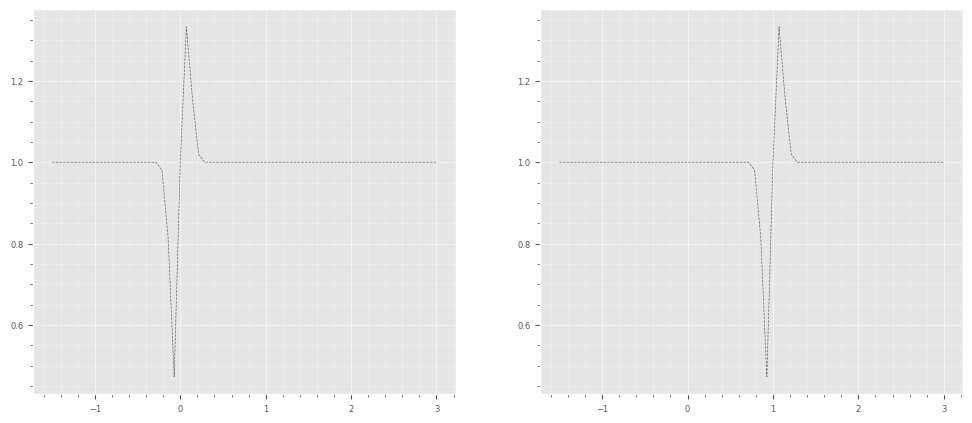

In [18]:
alphas=[0.0,1.0]
leps=[.25,.25]
t=np.linspace(-1.5,3,64)
fig,axes=plt.subplots(1,2,figsize=(12,5))
for i, alpha,eps in zip(range(len(alphas)),alphas,leps):
    x=[fold_on_one(alpha,eps,v) for v in t]
    plot_function(axes[i],t,x)

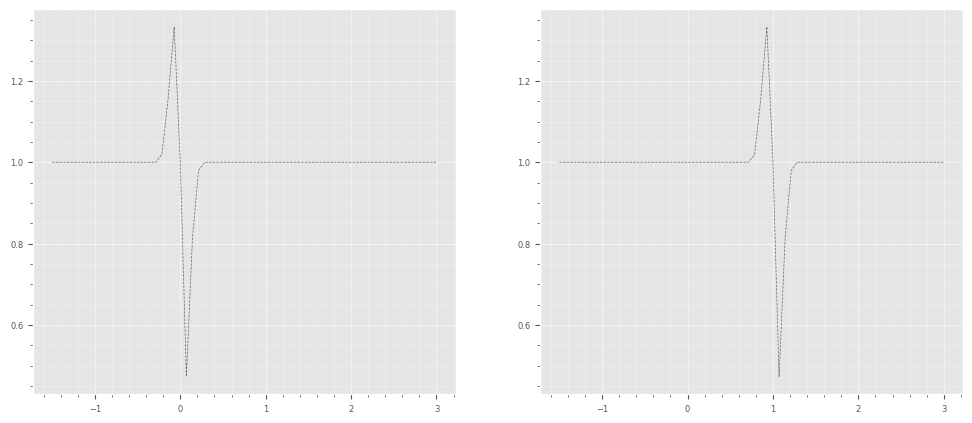

In [19]:
fig,axes=plt.subplots(1,2,figsize=(12,5))
for i, alpha,eps in zip(range(len(alphas)),alphas,leps):
    x=[unfold_on_one(alpha,eps,v) for v in t]
    plot_function(axes[i],t,x)

todo: 重新整理这部分材料

In [20]:
def unfold_unit(f,t,N=1):
    if t>0:
        return rcfis(t,N)*f(t)-rcfis(-t,N)*f(-t)
    elif t<0:
        return rcfis(-t,N)*f(t)+rcfis(t,N)*f(-t)
    else:
        return np.sqrt(.5)

In [21]:
def fold(f,alpha,eps,t,N=1):
    t1=(t-alpha)/eps
    if t>alpha and t<alpha+eps:
        return rcfis(t1,N)*f(t)+rcfis(-t1,N)*f(2*alpha-t)
    elif t>alpha-eps and t<alpha:
        return rcfis(-t1,N)*f(t)-rcfis(t1,N)*f(2*alpha-t)
    elif t==alpha:
        return np.sqrt(.5)*f(t) # 也可以用r(0,N)*f(t)
    else:
        return f(t)

def unfold(f,alpha,eps,t,N=1):
    t1=(t-alpha)/eps
    if t>alpha and t<alpha+eps:
        return rcfis(t1,N)*f(t)-rcfis(-t1,N)*f(2*alpha-t)
    elif t>alpha-eps and t<alpha:
        return rcfis(-t1,N)*f(t)+rcfis(t1,N)*f(2*alpha-t)
    elif t==alpha:
        return np.sqrt(.5)*f(t) # 也可以用r(0,N)*f(t)
    else:
        return f(t)

In [22]:
def unit_one(t):
    if t<0.0 or t>1.0:
        return 0.0
    else:
        return 1.0

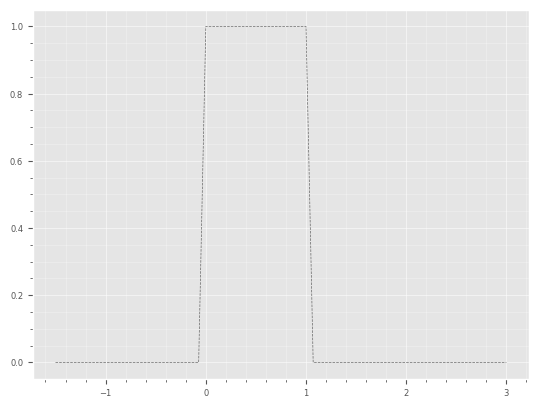

In [23]:
fig,ax=plt.subplots()
x=[unit_one(v) for v in t]
plot_function(ax,t,x)

### 左边磨光用$U^*$

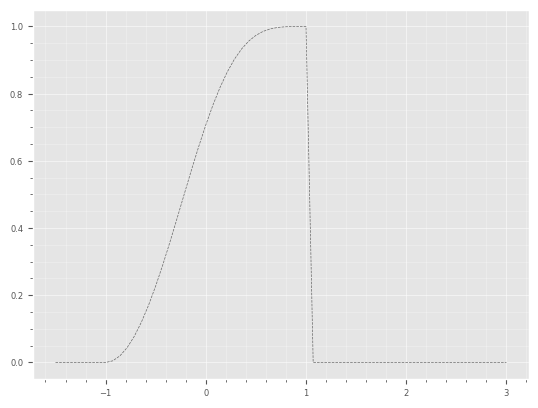

In [24]:
fig,ax=plt.subplots()
x=[unfold_unit(unit_one,v) for v in t]
plot_function(ax,t,x)

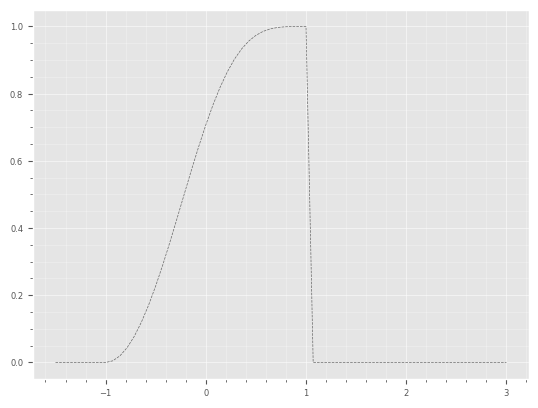

In [25]:
fig,ax=plt.subplots()
x=[unfold(unit_one,0,1.0,v) for v in t]
plot_function(ax,t,x)

### $U$作为右边磨光的算子

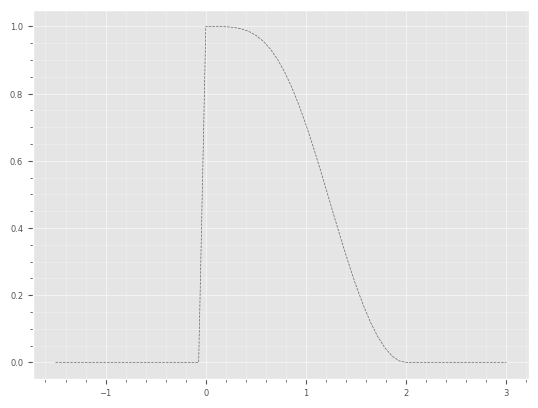

In [26]:
fig,ax=plt.subplots()
x=[fold(unit_one,1.0,1.0,v) for v in t]
plot_function(ax,t,x)

## 双边磨光
这个实验是对对区间$[0,1]$进行双边磨光。根据以上的分析，左边用算子$U^*$，右边用算子$U$。因为是复合运算，这里我们采用了partial函数的概念来定义右边的磨光。

另外一种算法就是利用左边和右边的操作是独立的，运算可以独立进行，但这需要对数组进行操作。而这里我们是对函数进行操作，故而采取了partial函数的概念。

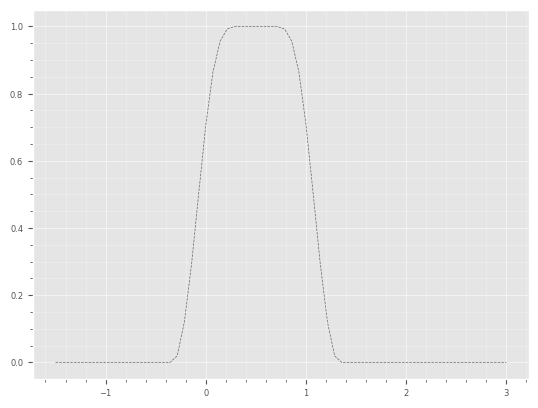

In [27]:
from functools import partial
def right(f,alpha,eps,t,N=1):
    return fold(f,alpha,eps,t,N)
f=partial(right,unit_one,1.0,1/3)
fig,ax=plt.subplots()
x=[unfold(f,0.0,1/3,v) for v in t]
plot_function(ax,t,x)

### 验证恒等式$U^*U=Id$:

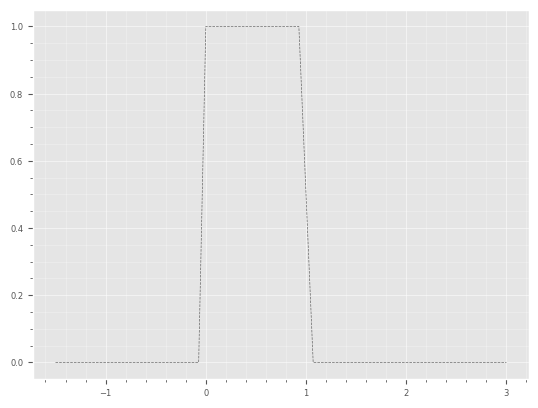

In [28]:
fig,ax=plt.subplots()
x=[unfold(f,1.0,1/3,v) for v in t]
plot_function(ax,t,x)

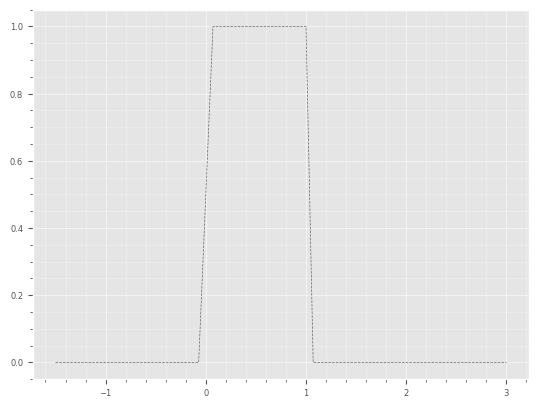

In [29]:
fig,ax=plt.subplots()
f=partial(right,unit_one,0.0,1/3)
x=[unfold(f,0.0,1/3,v) for v in t]
plot_function(ax,t,x)

## Bell函数
上面的磨光技术是对区间$[\alpha_1,\alpha_2]$在端点$\alpha_1$和$\alpha_2$分别用算子$U^*$（左端点）和$U$（右端点）对给定的函数进行磨光。其中的假设是函数在这个区间外值为零，而其中的原理是在左端以$\alpha_1$为中心向左做偶函数的延伸，利用函数在$\alpha_1$右边的值来决定$\alpha_1$左边的值，具体的做法就是乘上相应点上rising cutoff函数的值。类似的，右端点则是对函数在$\alpha_2$右边进行奇延伸（以$\alpha_2$为原点）。所以，在区间外函数值为零的条件下，算子$U^*$是对左端点的向左的偶延伸，算子$U$则是对右端点向右的奇延伸。

可以验证，在这种情况下，
\begin{equation}
U^*(r,\alpha_1,\epsilon_1)U(r,\alpha_2,\epsilon_2)f(t)=r\left(\frac{t-\alpha_1}{\epsilon_1}\right)
r\left(\frac{\alpha_2-t}{\epsilon_2}\right)f(t)
\end{equation}
令$B_\epsilon(\alpha)=[\alpha-\epsilon,\alpha+\epsilon]$，即$B_\epsilon(\alpha)$代表以$\alpha$为中心，半径为$\epsilon$的区间。我们要求$B_{\epsilon_1}(\alpha_1)\cap B_{\epsilon_2}(\alpha_2)=\emptyset$，也就是说，$B_{\epsilon_1}(\alpha_1)$与$B_{\epsilon_2}(\alpha_2)$不相交。

我们定义区间$I_k=[\alpha_k,\alpha_{k+1}]$上的bell函数为：
\begin{equation}
b_k(t)=r\left(\frac{t-\alpha_k}{\epsilon_k}\right)
r\left(\frac{\alpha_{k+1}-t}{\epsilon_{k+1}}\right)
\end{equation}
对于函数$f(t)$，$b_k(t)f(t)$就是对$f(t)$在区间$I_k$上的光滑截取。

In [30]:
# smooth bell_cutoff function
# param structure:
#   - param[0]: alpha
#   - param[1]: epsilon
#.  - param[2]: N (the number of iteration for the rising function)
# lparam: parameter for the left edge
# rparam: parameter for the right edge
# t: function is evaluated at t
def bell_cutoff(lparam,rparam,t):
    return rcfis((t-lparam[0])/lparam[1],lparam[2])*rcfis((rparam[0]-t)/rparam[1],rparam[2])

### 两相邻区间
对函数进行局部分析，关键就是对函数的局部截取，以上技术是对单一区间的一种系统性的光滑截取。现在我们来看看，相邻区间的情况。

相邻的情况可以推广到对整个数轴的破分。

(-1.0, 3.0)

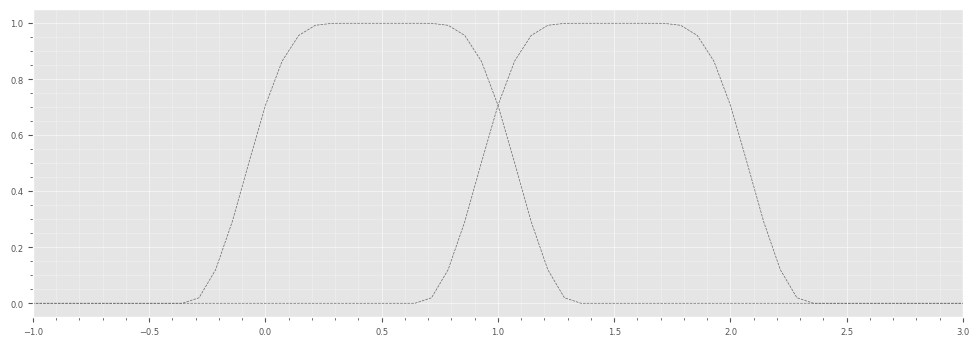

In [31]:
fig,ax=plt.subplots(figsize=(12,4))
param=[[0,1/3,1],[1,1/3,1],[2,1/3,1]]
# bell function on [-1/3,1+1/3]
x=[bell_cutoff(param[0],param[1],v) for v in t]
plot_function(ax,t,x)
# bell function on [1-1/3,2+1/3]
x1=[bell_cutoff(param[1],param[2],v) for v in t]
plot_function(ax,t,x1)
plt.xlim([-1,3])

### 两个相邻区间的合成
有了破分，我们来看看合成的情况，$I_3=I_1+I_2$，$I_1=[\alpha_1,\alpha_2]$，$I_2=[\alpha_2,\alpha_3]$, $I_3=[\alpha_1,\alpha_3]$，其中$\alpha_1<\alpha_2<\alpha_3$。

相应的bell函数我们分别用$b_k,\ k=1,2,3$来表示。他们之间的关系：

$$
b_3^2(t)=b_1^2(t)+b_2^2(t)
$$


(-1.0, 3.0)

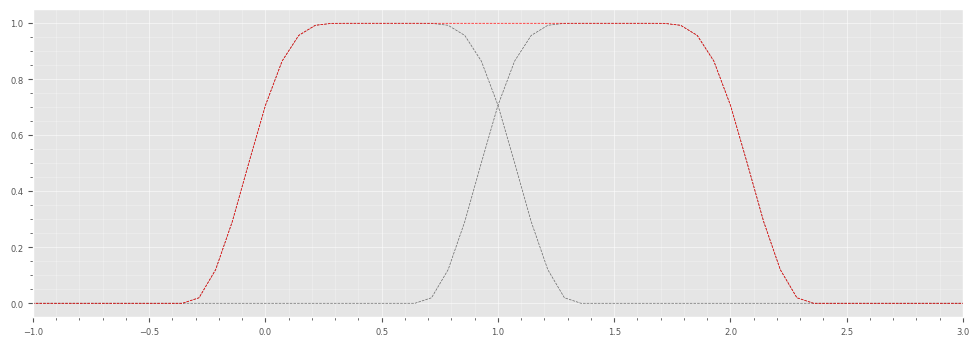

In [32]:
fig,ax=plt.subplots(figsize=(12,4))
param=[[0,1/3,1],[1,1/3,1],[2,1/3,1]]
# bell function on [-1/3,1+1/3]
b1=[bell_cutoff(param[0],param[1],v) for v in t]
plot_function(ax,t,b1)
# bell function on [1-1/3,2+1/3]
b2=[bell_cutoff(param[1],param[2],v) for v in t]
plot_function(ax,t,b2)
# bell function on [-1/3,2+1/3]
b3=[bell_cutoff(param[0],param[2],v) for v in t]
plot_function(ax,t,b3,color='red')
plt.xlim([-1,3])

验证恒等式：$b_3^2(t)=b_1^2(t)+b_2^2(t)$

In [33]:
flag=False
for bb3, bb2, bb1 in zip(b3,b2,b1):
    flag = np.isclose(bb3*bb3,bb2*bb2+bb1*bb1)
print(flag)

True


## 对实轴的分割
有了分割和合并的机制，我们就可以对实轴进行有系统的分割。第一层的分割为：

$$
\R = \bigcup_{k\in\Z}[k,k+1)\defeq\bigcup_{k\in\Z}I_{0,k}
$$

第二层，

$$
I_{1,k}\defeq\left[\frac{k}{2},\frac{k+1}{2}\right];\quad\R=\bigcup_{k\in\Z}I_{1,k}
$$

按这个逻辑一直可以分割到第$j$层：

$$
I_{j,k}\defeq\left[\frac{k}{2^j},\frac{k+1}{2^j}\right];\quad\R=\bigcup_{k\in\Z}I_{j,k}
$$

并且，

$$
I_{j,k}=I_{j+1,2k}\bigcup I_{j+1,2k+1}
$$

尤其是对第一层的中间区间$I{0,0}$，经过$L$层分割后，我们有

$$
I_{0,0}=\bigcup_{k=0}^{2^L-1}I_{L,k}
$$

令$b_{j,k}(t)$为$I_{j,k}$的bell函数，我们有恒等式，

$$
\left|b_{j,k}(t)\right|^2=\left|b_{j+1,2k}(t)\right|^2+\left|b_{j+1,2k+1}(t)\right|^2,\quad\forall t\in\R
$$

关于$\epsilon_j$的选取：一种方案是取$\epsilon=2^{-j-1}$，这就保证磨光区域不会重叠。{cite}`FARGE1992229`有关于这个问题的讨论。

# 左偶右奇函数的光滑延伸
这里的材料主要参考{cite}`Wickerhauser:1994`第4章。

## dct-iv中的基
*dct-iv*中的第$\nu$个基为：

$$
e_\nu^d(t)=\sqrt{\frac{2}{N}}\cos\frac{\pi}{N}\left(\nu+\frac{1}{2}\right)\left(t+\frac{1}{2}\right),\quad
t=0,1,2,\cdots,N-1
$$

这里$\nu\in[0,1,2,\cdots,N-1]$为频率域信息。*dct-iv*的特征为，在左边界，即$t=0$处，$e_\nu(t)$是关于$-1/2$的偶函数，而在右边界，也就是$t=N-1$处，$e_\nu(t)$是关于$N-1/2$的奇函数。

相对应的$\L^2[a,b]$上的一组基为

$$
e_\nu(t)=\sqrt{\frac{2}{b-a}}\cos\pi\left(\nu+\frac{1}{2}\right)\frac{t-a}{b-a},\quad\nu\in\Z
$$

如何提取`dct-iv`的基？两个方案，其一是将公式以函数的形式编写，另外一种方式就是在频率域上用$\delta$函数设定某个频率，然后用`dct-iv`逆变换获取时间域上的基函数。

### 公式编写
1. `dctiv`是对$e_\nu^d(t)$的编写，输入为频率`v`（对应于$\nu$）和样本个数`N`；输出为两个数组，第一个数组是在$[0,1]$区间的采样点，第二个数组代表$e_\nu^d(t)$的`N`个样本值。这里需要强调的是，函数的采样点为$[0,1,2,\cdots,N-1]$，对应于$[0,1)$区间上$N$个时间点：$[0,(1+1/2)/N,\cdots,(N-1+1/2)/N]$，输出的时间的采样点为后者。
2. `dctiv_fct`是`dctiv`的函数版本，增加时间点`t`，是任意一个整数；返回值为$e_\nu^d(t)$。
3. `dct_fct`是对余弦函数$e_\nu(t)$的编写，符号与公式相符。

In [34]:
def dctiv(v,N):
    t=[(t+0.5)/N for t in range(N)]
    w=np.sqrt(2.0/N)
    sig = [w*np.cos(np.pi*(v+.5)*u) for u in t]
    return [t,sig]

def dctiv_fct(v,N,t):
    w=np.sqrt(2.0/N)
    u=np.pi*(v+0.5)/N
    return w*np.cos(u*(t+0.5))

# continuous version for L^2[a_1,a_2]
def dct_fct(v,a,b,t):
    if a>=b:
        raise Exception('a>=b')
    w=np.sqrt(2/(b-a))
    nu=np.pi*(v+0.5)
    u=(t-a1)/(b-a)
    return w*np.cos(nu*u)

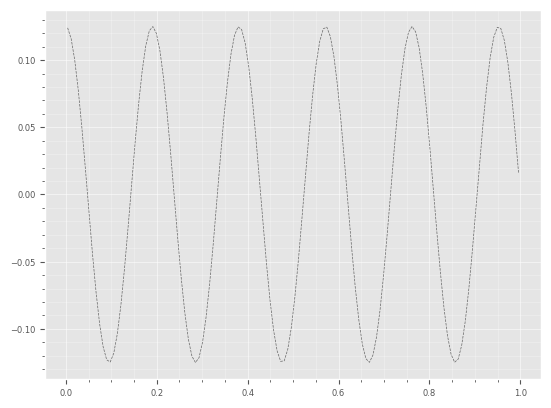

In [35]:
N=128
t,sig=dctiv(10,N)
fig,ax=plt.subplots()
plot_function(ax,t,sig)

### 从逆变换获取基函数
通过逐一遍历所有的频率，通过逆变换我们可以获取基函数：

In [36]:
e=np.ndarray(shape=(N,N),dtype=float)
for v in range(N):
    delta=np.repeat(0.0,N)
    delta[v]=1
    e[v]=scipy.fft.idct(delta,type=4,norm="ortho")

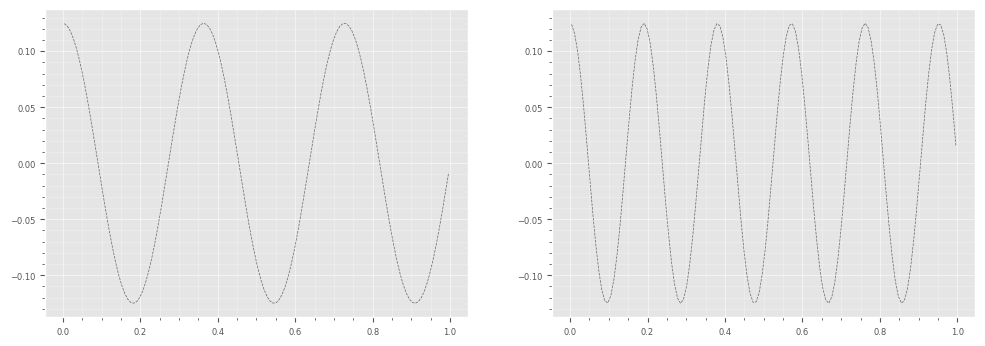

In [37]:
fig,axes=plt.subplots(1,2,figsize=[12,4])
plot_function(axes[0],t,e[5])
plot_function(axes[1],t,e[10])

### 验证关于$1/2$偶函数的性质

In [38]:
for v in range(10,35,5):
    print('N=',N,'v=',v)
    for i in range(1,5):
        print('dctiv(',-i,')=',dctiv_fct(v,N,-i),',   dctiv(',i-1,')=',dctiv_fct(v,N,i-1))

N= 128 v= 10
dctiv( -1 )= 0.12396371920863744 ,   dctiv( 0 )= 0.12396371920863744
dctiv( -2 )= 0.11577628026728892 ,   dctiv( 1 )= 0.11577628026728892
dctiv( -3 )= 0.09994215863848813 ,   dctiv( 2 )= 0.09994215863848813
dctiv( -4 )= 0.07750715147041115 ,   dctiv( 3 )= 0.07750715147041115
N= 128 v= 15
dctiv( -1 )= 0.1227454836386944 ,   dctiv( 0 )= 0.1227454836386944
dctiv( -2 )= 0.1051943721796123 ,   dctiv( 1 )= 0.1051943721796123
dctiv( -3 )= 0.07260174476197058 ,   dctiv( 2 )= 0.07260174476197058
dctiv( -4 )= 0.029627950749295917 ,   dctiv( 3 )= 0.029627950749295917
N= 128 v= 20
dctiv( -1 )= 0.12106526178430216 ,   dctiv( 0 )= 0.12106526178430216
dctiv( -2 )= 0.09105804880602816 ,   dctiv( 1 )= 0.09105804880602816
dctiv( -3 )= 0.03848120500519187 ,   dctiv( 2 )= 0.03848120500519187
dctiv( -4 )= -0.023633583018725743 ,   dctiv( 3 )= -0.023633583018725743
N= 128 v= 25
dctiv( -1 )= 0.11892937762112604 ,   dctiv( 0 )= 0.11892937762112604
dctiv( -2 )= 0.0738449627323593 ,   dctiv( 1 )= 0

In [39]:
a1=0.0
a2=1.0
dt=.01
for v in range(10,35,5):
    print('v=',v,'a1=',a1,'a2=',a2)
    for n in range(1,5):
        print('dct(',a1-n*dt,')=',dct_fct(v,a1,a2,a1-n*dt),',  dct(',a1+n*dt,')=',dct_fct(v,a1,a2,a1+n*dt))

v= 10 a1= 0.0 a2= 1.0
dct( -0.01 )= 1.3379667456165307 ,  dct( 0.01 )= 1.3379667456165307
dct( -0.02 )= 1.1174479348787822 ,  dct( 0.02 )= 1.1174479348787822
dct( -0.03 )= 0.7764355152652535 ,  dct( 0.03 )= 0.7764355152652535
dct( -0.04 )= 0.35170061125357227 ,  dct( 0.04 )= 0.35170061125357227
v= 15 a1= 0.0 a2= 1.0
dct( -0.01 )= 1.2498333400306343 ,  dct( 0.01 )= 1.2498333400306343
dct( -0.02 )= 0.7949059361429642 ,  dct( 0.02 )= 0.7949059361429642
dct( -0.03 )= 0.15518775100262472 ,  dct( 0.03 )= 0.15518775100262472
dct( -0.04 )= -0.5206067350492003 ,  dct( 0.04 )= -0.5206067350492003
v= 20 a1= 0.0 a2= 1.0
dct( -0.01 )= 1.1309248896541404 ,  dct( 0.01 )= 1.1309248896541404
dct( -0.02 )= 0.3945530059421486 ,  dct( 0.02 )= 0.3945530059421486
dct( -0.03 )= -0.4998889180303361 ,  dct( 0.03 )= -0.4998889180303361
dct( -0.04 )= -1.1940600033352897 ,  dct( 0.04 )= -1.1940600033352897
v= 25 a1= 0.0 a2= 1.0
dct( -0.01 )= 0.9841693151698401 ,  dct( 0.01 )= 0.9841693151698401
dct( -0.02 )= -0.0

### 验证关于$N-1/2$奇函数的性质

In [40]:
for v in range(10,35,5):
    print('N=',N,'v=',v)
    for i in range(1,5):
        print('dctiv(',N-i,')=',dctiv_fct(v,N,N-i),',   dctiv(',N+i-1,')=',dctiv_fct(v,N,N+i-1))

N= 128 v= 10
dctiv( 127 )= 0.016062263849224444 ,   dctiv( 128 )= -0.016062263849224566
dctiv( 126 )= 0.04712592627705241 ,   dctiv( 129 )= -0.04712592627705252
dctiv( 125 )= 0.0750770599229836 ,   dctiv( 130 )= -0.07507705992298368
dctiv( 124 )= 0.09806957464444678 ,   dctiv( 131 )= -0.09806957464444686
N= 128 v= 15
dctiv( 127 )= -0.0236335830187265 ,   dctiv( 128 )= 0.0236335830187256
dctiv( 126 )= -0.06752143409123695 ,   dctiv( 129 )= 0.06752143409123618
dctiv( 125 )= -0.1017545412132436 ,   dctiv( 130 )= 0.10175454121324305
dctiv( 124 )= -0.12143798637328163 ,   dctiv( 131 )= 0.1214379863732814
N= 128 v= 20
dctiv( 127 )= 0.03111595071821616 ,   dctiv( 128 )= -0.031115950718214266
dctiv( 126 )= 0.08563545847158804 ,   dctiv( 129 )= -0.08563545847158727
dctiv( 125 )= 0.11892937762112638 ,   dctiv( 130 )= -0.1189293776211255
dctiv( 124 )= 0.1227454836386943 ,   dctiv( 131 )= -0.12274548363869467
N= 128 v= 25
dctiv( 127 )= -0.03848120500519255 ,   dctiv( 128 )= 0.03848120500519139
dct

In [41]:
a1=0.0
a2=1.0
dt=.01
for v in range(10,35,5):
    print('关于a2为奇函数的验证： v=',v,', a1=',a1,', a2=',a2)
    for n in range(1,5):
        print('dct(',a2-n*dt,')=',dct_fct(v,a1,a2,a2-n*dt),',  dct(',a2+n*dt,')=',dct_fct(v,a1,a2,a2+n*dt))

关于a2为奇函数的验证： v= 10 , a1= 0.0 , a2= 1.0
dct( 0.99 )= 0.45808840590470323 ,  dct( 1.01 )= -0.45808840590470457
dct( 0.98 )= 0.866781467750171 ,  dct( 1.02 )= -0.866781467750172
dct( 0.97 )= 1.1820101059782784 ,  dct( 1.03 )= -1.182010105978279
dct( 0.96 )= 1.3697834427543147 ,  dct( 1.04 )= -1.3697834427543163
关于a2为奇函数的验证： v= 15 , a1= 0.0 , a2= 1.0
dct( 0.99 )= -0.6617526895660351 ,  dct( 1.01 )= 0.661752689566026
dct( 0.98 )= -1.169668565314416 ,  dct( 1.02 )= 1.1696685653144103
dct( 0.97 )= -1.4056730636740362 ,  dct( 1.03 )= 1.4056730636740349
dct( 0.96 )= -1.3149025163187602 ,  dct( 1.04 )= 1.314902516318764
关于a2为奇函数的验证： v= 20 , a1= 0.0 , a2= 1.0
dct( 0.99 )= 0.8491224257789807 ,  dct( 1.01 )= -0.849122425778963
dct( 0.98 )= 1.3580603541455827 ,  dct( 1.02 )= -1.3580603541455736
dct( 0.97 )= 1.322917635240551 ,  dct( 1.03 )= -1.3229176352405552
dct( 0.96 )= 0.7577735205421917 ,  dct( 1.04 )= -0.7577735205422106
关于a2为奇函数的验证： v= 25 , a1= 0.0 , a2= 1.0
dct( 0.99 )= -1.0155839497934913 ,

## 逆折叠算子对于区间$[\alpha_1,\alpha_2]$上左偶右奇函数的光滑延伸
令对区间$[\alpha_1,\alpha_2]$的截断函数为$I_{[\alpha_1,\alpha_2]}$，即

$$
I_{[\alpha_1,\alpha_2]}(t)=\left\{
\begin{array}{cl}
1,&\textrm{if}\quad t\in[\alpha_1,\alpha_2]\\
0,&\textrm{其他}
\end{array}
\right.
$$

我们考虑当函数$f(t)$关于$\alpha_1$为偶函数，而关于$\alpha_2$为奇函数的情况。当$\alpha_1<t<\alpha+\epsilon$,

$$
\begin{array}{ccl}
U^*(r,\alpha_1,\epsilon_1)I_{[\alpha_1,\alpha_2]}(t)f(t)
&=&
\bar{r}\left(\frac{t-\alpha_1}{\epsilon_1}\right)I_{[\alpha_1,\alpha_2]}(t)f(t)
-r\left(\frac{\alpha_1-t}{\epsilon_1}\right)I_{[\alpha_1,\alpha_2]}(2\alpha_1-t)f(2\alpha_1-t)\\
&=&
\bar{r}\left(\frac{t-\alpha_1}{\epsilon_1}\right)f(t-\alpha_1)
\end{array}
$$

这是因为，对于$\alpha_1<t<\alpha_1+\epsilon$，$I_{[\alpha_1,\alpha_2]}(t)=1$和$I_{[\alpha_1,\alpha_2]}(2\alpha_1-t)=0$，而且因为$f(t)$是关于$\alpha_1$的偶函数，$f(2\alpha_1-t)=f(\alpha_1+(\alpha_1-t))=f(-(\alpha_1-t))=f(t-\alpha_1)$。

类似地，对于$\alpha_1-\epsilon_1<t<\alpha_1$,

$$
\begin{array}{ccl}
U^*(r,\alpha_1,\epsilon_1)I_{[\alpha_1,\alpha_2]}(t)f(t)
&=&
r\left(\frac{\alpha_1-t}{\epsilon_1}\right)I_{[\alpha_1,\alpha_2]}(t)f(t)
+\bar{r}\left(\frac{t-\alpha_1}{\epsilon_1}\right)I_{[\alpha_1,\alpha_2]}(2\alpha_1-t)f(2\alpha_1-t)\\
&=&
\bar{r}\left(\frac{t-\alpha_1}{\epsilon_1}\right)f(\alpha_1+(\alpha_1-t))\\
&=&
\bar{r}\left(\frac{t-\alpha_1}{\epsilon_1}\right)f(t-\alpha_1)
\end{array}
$$

所以，

$$
U^*(r,\alpha_1,\epsilon_1)I_{[\alpha_1,\alpha_2]}(t)f(t)=
\left\{
\begin{array}{cl}
\bar{r}\left(\frac{t-\alpha_1}{\epsilon_1}\right)f(t-\alpha_1),&\textrm{if}\quad\alpha_1<t<\alpha_1+\epsilon_1\\
\bar{r}\left(\frac{t-\alpha_1}{\epsilon_1}\right)f(-(t-\alpha_1)),&\textrm{if}\quad\alpha_1-\epsilon_1<t<\alpha_1\\
f(t),&\textrm{其他}
\end{array}
\right.
$$

利用$f(t)$关于$\alpha_2$为奇函数的特点，同样的演算，我们可以得到，

$$
U^*(r,\alpha_2,\epsilon_2)I_{[\alpha_1,\alpha_2]}(t)f(t)=
\left\{
\begin{array}{cl}
-r\left(-\frac{t-\alpha_2}{\epsilon_2}\right)f(-(t-\alpha_2)),&\textrm{if}\quad\alpha_2<t<\alpha_2+\epsilon_2\\
r\left(-\frac{t-\alpha_2}{\epsilon_2}\right)f(t-\alpha_2),&\textrm{if}\quad\alpha_2-\epsilon_2<t<\alpha_2\\
f(t),&\textrm{其他}
\end{array}
\right.
$$


### 作用于$I_[\alpha_1,\alpha_2](t)$的情况

In [42]:
def cutoff(a1,a2,t):
    if (a1>a2):
        raise Exception("a1>a2")
    if t<a1 or t>a2:
        return 0.0
    else:
        return 1.0

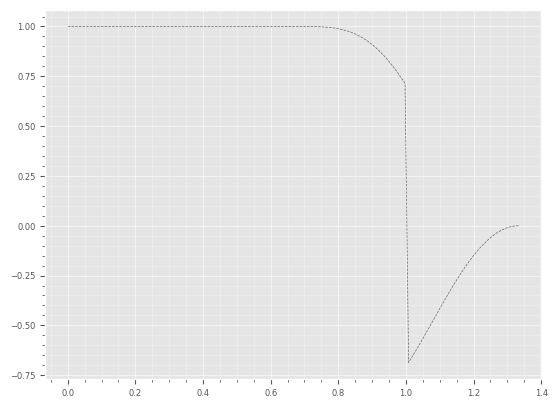

In [43]:
fig,ax=plt.subplots()
N=128
t=np.linspace(0,1+1/3,N)
f=partial(cutoff,0.0,1.0)
x=[unfold(f,1.0,1/3,v) for v in t]
plot_function(ax,t,x)

### 加上左偶右奇函数的情况

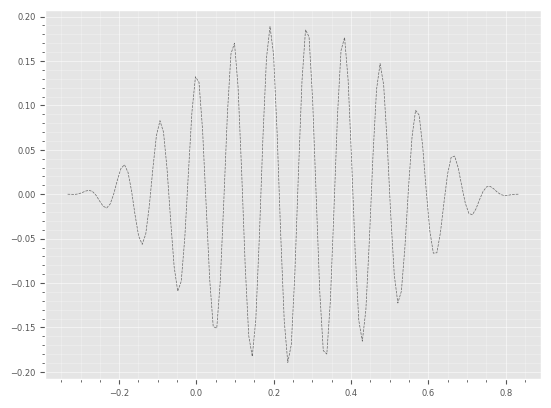

In [44]:
# define a cutoff function extending the function defined on [a1,a2], outside [a1,a2] to be zero
def cutoff_fct(f,v,a1,a2,nf,t):
    return nf*cutoff(a1,a2,t)*f(v,a1,a2,t)
N=128
t=np.linspace(-1/3,0.5+1/3,N,dtype=float)
nf=np.sqrt(t[1]-t[0])
f=partial(cutoff_fct,dct_fct,10,0,.5,nf) # extending dct defined on [0,0.5] to be zero outside [0,0.5] 
unfold_right=partial(unfold,f,0.5,1/3) # unfold right at .5
x=[unfold(unfold_right,0.0,1/3,v) for v in t] # unfold left at 0.0
fig,ax=plt.subplots()
plot_function(ax,t,x)

In [45]:
np.linalg.norm(x)

1.0000000000188851

voila! 这就是在区间$[0,0.5]$上左偶右奇函数通过两个逆折叠算子的光滑延伸。这个技术奠定了`lct`的理论基础。

### 与bell函数的关系
这里我们看到，只要$f(t)$是关于$\alpha_1$为偶函数，同时关于$\alpha_2$为奇函数，我们就有

$$
\begin{array}{ccl}
U^*(r,\alpha_1,\epsilon_1)U^*(r,\alpha_2,\epsilon_2)I_{[\alpha_1,\alpha_2]}(t)f(t)&=&b_{\alpha_1,\alpha_2}(t)f(t)\\
&=&r\left(\frac{t-\alpha_1}{\epsilon_1}\right)r\left(\frac{\alpha_2-t}{\epsilon_2}\right)f(t)
\end{array}
$$

## 内积
令$\{e_\nu(t)\}_{\nu\in\Z}$为$L^2[a,b]$的一组基，其中每个$e_\nu(t)$具备关于左端点为偶函数，右端点为奇函数的特征。

有人可能会问，既然对于$e_\nu(t)$在区间$[a,b]$的光滑延伸能够通过bell函数来实现：

$$
U^*(r,a,\epsilon)U^*(r,b,\epsilon)I_{[a,b]}(t)e_\nu(t)=r\left(\frac{t-a}{\epsilon}\right)r\left(\frac{b-t}{\epsilon}\right)e_\nu(t)
$$

我们不就可以不用折叠和逆折叠算子，直接用bell函数就行了。以下的恒等式回答了这个问题，也是问题的关键所在：我们求一个函数$f(t)$在$e_\nu(t)$上的表达，就是求其内积$<f,\ e_\nu>$，那么对于光滑延伸后的基，$U^*(r,a,\epsilon)U^*(r,b,\epsilon)I_{[a,b]}(t)e_\nu(t)$，我们需要求$<f,\ U^*(r,a,\epsilon)U^*(r,b,\epsilon)I_{[a,b]}(t)e_\nu(t)>$，不难验证

\begin{equation}
<f(\cdot),\ U^*(r,a,\epsilon)U^*(r,b,\epsilon)I_{[a,b]}(\cdot)e_\nu(\cdot)>=<U(r,b,\epsilon)U(r,a,\epsilon)f(\cdot),\ I_{[a,b]}(\cdot)e_\nu(\cdot)>
\end{equation}

这个公式意义重大，与其对基函数$I_{[a,b]}e_\nu(t)$进行光滑延伸，我们对被分析函数$f(t)$进行折叠，由于被分析函数并不满足奇函数和偶函数的假定，这就需要我们采纳折叠算子。

首先我们来定义两个函数，`UsUs(f,a,b,eps,t)`和`UU(f,a,b,eps,t)`分别对应于$U^*(r,a,\epsilon)U^*(r,b,\epsilon)f(t)$和$U(r,a,\epsilon)U(r,b,\epsilon)f(t)$，rcf函数隐含在`unfold`和`fold`（这个设计不太合理，后续会作相应的修改），其他的符合意义与公式符合，当然，`eps`指的是$\epsilon$，`f`是被作用的函数，在python中，函数可以作为函数中的输入变量。这里的`f`如果要求其他变量作为输入，那么我们会采用`partial`函数来处理，这个处理方法可以参考下面的例子。

In [46]:
def UsUs(f,a,b,eps,t):
    right=partial(unfold,f,b,eps)
    return unfold(right,a,eps,t)

def UU(f,a,b,eps,t):
    left=partial(fold,f,a,eps)
    return fold(left,b,eps,t)

### 求$<f(\cdot),U^*(r,a,\epsilon)U^*(r,b,\epsilon)I_{[a,b]}(\cdot)e_\nu(\cdot)>$

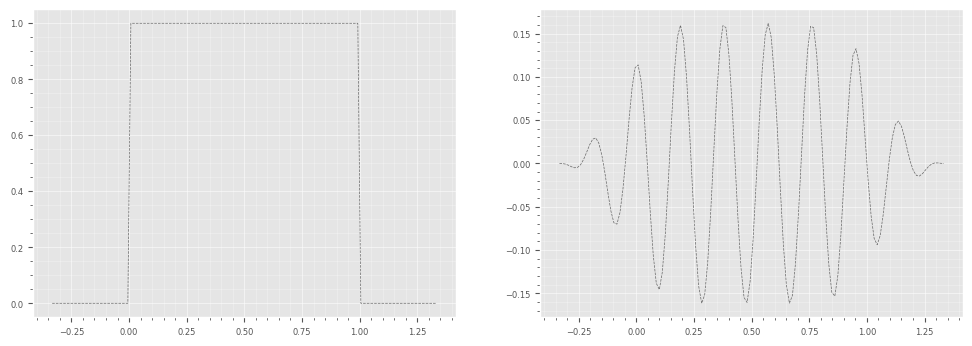

In [47]:
a=0.0
b=1.0
eps=1/3
N=128
v=10
t=np.linspace(-eps,1+eps,N,dtype=float)
nf=np.sqrt(t[1]-t[0])
f=partial(cutoff_fct,dct_fct,v,a,b,nf)
ev=np.array([UsUs(f,a,b,eps,u) for u in t], dtype=float)
#ev=ev/np.linalg.norm(ev)
x=np.array([cutoff(a,b,u) for u in t],dtype=float)
#x=x/np.linalg.norm(x)
fig,axes=plt.subplots(1,2,figsize=[12,4])
plot_function(axes[0],t,x)
plot_function(axes[1],t,ev)

In [48]:
print(np.linalg.norm(x),np.linalg.norm(ev))

8.717797887081348 1.000000000140259


In [49]:
rinner=np.dot(x,ev)

### 计算$<U(r,b,\epsilon)U(r,a,\epsilon)f(\cdot),I_{[a,b]}(\cdot)e_\nu(\cdot)>$

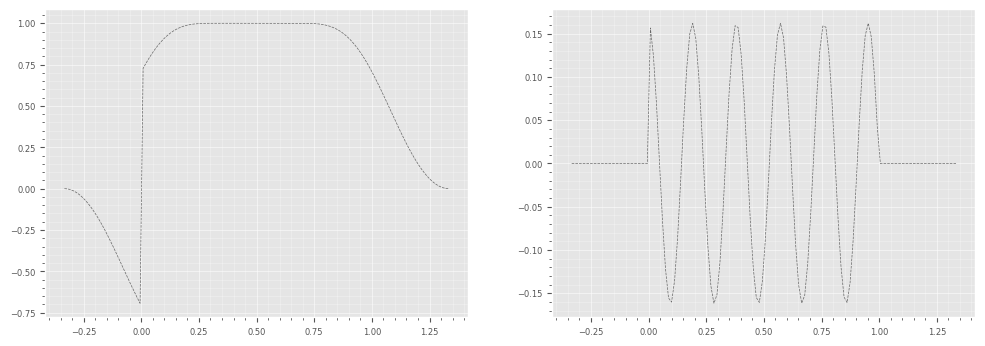

In [50]:
evp=np.array([cutoff_fct(dct_fct,v,a,b,nf,u) for u in t], dtype=float)
#evp=evp/np.linalg.norm(evp)
f=partial(cutoff,a,b)
xp=np.array([UU(f,a,b,eps,u) for u in t],dtype=float)
#xp=xp/np.linalg.norm(xp)
fig,axes=plt.subplots(1,2,figsize=[12,4])
plot_function(axes[0],t,xp)
plot_function(axes[1],t,evp)

In [51]:
linner=np.dot(xp,evp)

### 比较两种方法的结果

```{note}
如果我们对所有的序列都进行范数的归一化，结果会更好。
```

In [52]:
print(rinner-linner)

-2.220446049250313e-16


In [53]:
print(np.linalg.norm(xp),np.linalg.norm(evp),np.linalg.norm(x),np.linalg.norm(ev))

8.72926113834243 0.9986868017972356 8.717797887081348 1.000000000140259


# 局部傅里叶变换
参考资料：
1. {cite}`Wickerhauser:1994`第四章，比较有系统地对LCT技术进行梳理，也对算法进行了详细的介绍。
2. {cite}`Mallat:2008`$\S$8.3,$\S$8.4,$\S$8.5: 理论上比较系统地介绍。
3. {cite}`Jawerth:1995`: 早期这方面有代表性的论文。

## 单区间局部余弦函数变换（LCT）
在概念上，我们考虑信号空间$\L^2(\R)$（在对信号周期化后，我们可以考虑$\L^2[0,1]$，这里为了保证理论上的严密性，我们在整个实轴上考虑问题)，给定一个区间$[a,b]$，如何计算区间$[a,b]$上的余弦函数变换。

### 算法之一：直接计算内积
1. 计算$\{U^*(r,a,\epsilon)U^*(r,b,\epsilon)I_{[a,b]}(t)e_\nu(t)\}$


### 算法之二：对被分析信号继续延伸，然后用快速余弦变换计算内积

## 两个相邻区间的局部余弦函数变换

## 信号的周期化

## 自适应性局部余弦函数变换

## 其他三角函数

```{bibliography}
:filter: docname in docnames
```
